# TouchPass Analysis

The data for this analysis is from May 2021 and comes from the TouchPass API. The first half of the analysis will be a basic exploratory analysis and will generate some statistics and figures for the overall usage of the TouchPass system. The second half of the analysis will look at the utilization of the daily fare capping feature that is possible through the TouchPass system. Fare capping is an equitable practice in public transit whereby passengers who pay their fares using 'stored value' will ride for free once their usage reaches the amount spent for a daily or monthly pass. For example, a daily pass is \\$5.00. Once a passenger pays \\$5.00 in a day using stored value, whatever trips they take beyond that are free for the rest of the day.

In [60]:
# Import libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns = 999

Next, we'll pass in the parameters to the TouchPass API and then make the call to the API.

In [2]:
# define parameters
url = 'https://touchpass.com/ams/rest/v1/reporting/faretx/'
api_key = os.environ.get('TOUCHPASS_API_KEY')

start = '2021-05-01T10:00:00Z'
end = '2021-06-01T04:00:00Z'

headers = {
    'accept': 'application/json',
    'Api-Token': api_key,
    'Agency-ID': '9K7A4H9JHRVQ'
}

In [3]:
%%time

# call api and save to variable
response = requests.get(url + start + '/' + end, headers=headers).json()

# write response to dataframe
df = pd.DataFrame(response)

print('Finished reading {:,} transactions'.format(len(df)))

Finished reading 8,643 transactions
Wall time: 2.59 s


In [4]:
# preview data
df.head(3)

,txId,ts,type,mediaUsed,mediaType,cardNumber,fareType,accountId,routeName,latitude,longitude,reader,readerPosition,fare,stopName,stopId,passUsed,vehicle
0,4900000000007651,2021-05-01T10:27:12.607Z,MONTHLY_CAP_REACHED,HOUSE,HOUSE_CARD,8028816339076671,Employee,3164081,DEFAULT,36.093978,-79.959275,H2R217,0,0,NaN,NaN,NaN,NaN
1,4990000000004544,2021-05-01T10:57:07.240Z,TRIP_PASS,HOUSE,HOUSE_CARD,8002762949719302,Full Fare,3175928,2,36.069205,-79.786919,H2R252,0,0,Greensboro Depot,142,Full Fare 10 Ride,NaN
2,5230000000005269,2021-05-01T10:57:55.861Z,TRIP_PASS,HOUSE,HOUSE_CARD,8084343859045235,Half Priced,3142217,3,35.957476,-80.007037,H2R263,0,0,High Point Terminal (Outer Slip),225,Half Fare 10 Ride,NaN


The dataframe above gives us a preview of what the data looks like. Let's take another look at it before we start to process it.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8643 entries, 0 to 8642
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   txId            8643 non-null   int64  
 1   ts              8643 non-null   object 
 2   type            8643 non-null   object 
 3   mediaUsed       8643 non-null   object 
 4   mediaType       8643 non-null   object 
 5   cardNumber      8643 non-null   object 
 6   fareType        8643 non-null   object 
 7   accountId       8643 non-null   int64  
 8   routeName       8643 non-null   object 
 9   latitude        8643 non-null   float64
 10  longitude       8643 non-null   float64
 11  reader          8643 non-null   object 
 12  readerPosition  8643 non-null   int64  
 13  fare            8643 non-null   int64  
 14  stopName        7829 non-null   object 
 15  stopId          7829 non-null   object 
 16  passUsed        3377 non-null   object 
 17  vehicle         1059 non-null   o

We need to convert `ts` or timestamp to a datetime object. We'll also convert the time to Eastern Standard time and create a few attributes for date and time. Then we'll drop a few columns that are of no interest to the analysis.

In [6]:
# Convert ts to a datetime object
df['ts'] = pd.to_datetime(df['ts'])
# Create new Date field and convert ts from UTC to local time
df['date'] = df['ts'].dt.tz_convert('US/Eastern')
# Create date only field
df['date_only'] = df['date'].dt.date
df['time_only'] = [dt.datetime.time(d) for d in df['date']]

In [7]:
sdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [8]:
cols_to_drop = ['txId', 'ts', 'mediaUsed', 'accountId', 'reader', 'readerPosition', 'vehicle', 'latitude', 'longitude']

In [9]:
sdf.drop(cols_to_drop, axis=1, inplace=True)

With our data set converted, we will visualize any missing data.

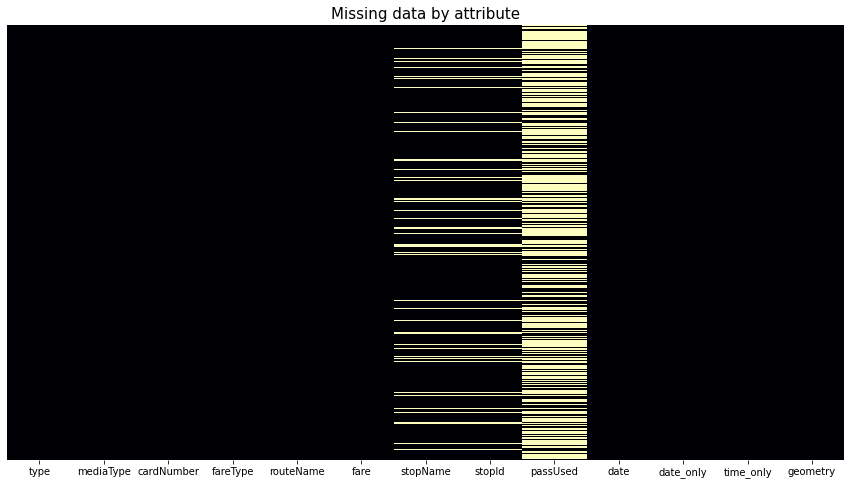

In [10]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(sdf.isnull(), cbar=False, cmap='magma')
plt.yticks([])
plt.title('Missing data by attribute', fontsize=15)
plt.show()

We can see that there are a few missing values in the `stopName` and `stopId` attributes. There are even more missing values in the `passUsed` attributes. What this tells us is that most transactions have been completed using stored value which acts as cash and there is no pass used.

Let's learn a little more about which passes have been used.

In [11]:
sdf['passUsed'].value_counts().to_frame()

,passUsed
Full Fare 10 Ride,1060
UNC XPass 2020-21,673
Half Fare 10 Ride,647
Half Fare 31 Day,215
Student 31 Day,169
Free One Way PT,139
One Way PT,135
Triad XPass 10 Ride,114
Full Fare 31 Day,83
Student 10 Ride,57


We can see that there are a variety of passes used on PART Express but the most common pass is the `Full Fare 10 Ride`. There also appears to be an equal number of `UNC XPass` and `Half Fare 10 Ride` passes used in the month of May. We also see that the `Triad XPass 10 Ride` is more popular than the `XPass 31 Day` pass.

Let's see how many unique `cardNumber`s there are in the data set. We might assume this number represents the unique passengers in the system.

In [12]:
# unique users in data set
len(sdf['cardNumber'].unique())

836

We can see that there are 836 unique card numbers in the data set. 

Let's look at the types of transactions...

In [13]:
sdf['type'].value_counts().to_frame()

,type
TRANSFER,2378
TRIP_PASS,2206
STORED_VALUE,1238
DAILY_CAP_REACHED,959
MONTHLY_CAP_REACHED,699
CALENDAR_PASS,673
TIME_PASS,490


In [14]:
sdf['type'].value_counts(normalize=True).to_frame()*100

,type
TRANSFER,27.513595
TRIP_PASS,25.523545
STORED_VALUE,14.323730
DAILY_CAP_REACHED,11.095684
MONTHLY_CAP_REACHED,8.087470
CALENDAR_PASS,7.786648
TIME_PASS,5.669328


Looking at the types of transactions, we can see that `TRANSFER` is the most common. The second table shows that transfers account for about 27% of transactions in May in the TouchPass system. Only about 14% or 1,238 transactions used `STORED VALUE`.

In [15]:
# group by cardNumber and date
all_cards_by_date = sdf.groupby(['cardNumber', 'date_only']).size().to_frame()

# rename column
all_cards_by_date.rename(columns={0: 'Count'}, inplace=True)

In [16]:
all_cards_by_date.sum(level='cardNumber').sort_values(by='Count', ascending=False)[0:5]

,Count
cardNumber,
8043099273812846,94
8002762949719302,86
7836721698662976,81
8084965856722984,80
8040448200289326,78


The table above shows the top 5 card numbers by number of transactions. We can see that one passenger had 94 transactions in the month of May. Let's take a look at the average number of transactions by card number.

In [17]:
all_cards_by_date.mean(level='cardNumber').sort_values(by='Count', ascending=False)[0:5]

,Count
cardNumber,
8085476407283467,6.000000
7096424500002979,5.916667
8005074717035789,5.428571
8079064859863347,5.000000
8059132773694942,5.000000


We can see that the highest daily average is 6.0 transactions. 

Let's see how many stops passengers utilize.

In [18]:
all_cards_by_stop = sdf.groupby('cardNumber')['stopName'].nunique().sort_values(ascending=False)

In [19]:
all_cards_by_stop.to_frame()[0:5]

,stopName
cardNumber,
8052921885342607,8
8015331484731141,8
8002150993129240,8
8084182476520810,7
8066038346750072,7


The table shows the top five card numbers with the most unique stop activity. We can see that three passengers utilized as many as 8 stops while at least two passengers accessed the system from 7 different stops in the month of May.

In [20]:
bar_order = [
    '1', '2', '3', '4', '5', '6', '9', '10', '17',
    '20', '21', '22', '23', '24', '20/21', '22/23',
    'North Shuttle', 'South Shuttle', 'DEFAULT'
]

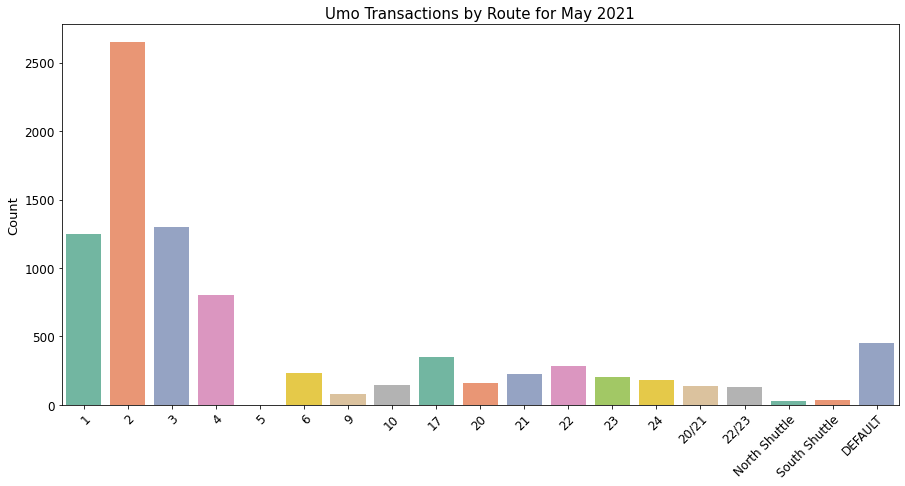

In [21]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x=sdf['routeName'], order=bar_order, palette='Set2')
plt.title('Umo Transactions by Route for May 2021', fontsize=15)
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('Count', fontsize=13)
plt.show()

The bar plot above shows the number of transactions by route for the month of May. We can see that the majority of Umo transactions occurred on Route 2. The transactions appear to be evenly split among Routes 1 and 3. There are also slightly less transactions on Route 4. The remaining routes seem to have low utilization.

### Daily Fare Cap Utilization

Let's take a look at the utilization of the daily fare capping. We'll first need to filter for passengers who use stored value and do not use some sort of pass. We'll also remove any employees.

In [22]:
# create array of card numbers who use stored value and are not employees
sv_users = sdf.loc[(sdf['type'] == 'STORED_VALUE') & (sdf['fareType'] != 'Employee'), 'cardNumber'].unique()

In [23]:
# create data set of trips of those users who used store value
sv_user_trips = sdf[sdf['cardNumber'].isin(sv_users)]

In [24]:
# create index for days in May and create list for day of week name
may_days = pd.date_range(start='2021-05-01', end='2021-05-31')
dow_names = may_days.day_name()

daily_cap_reached = []
daily_passengers = []

for day in may_days:
    # create dataframe for each day
    x = sv_user_trips[sv_user_trips['date_only'] == day]
    
    # get number of unique card numbers who reached their daily fare cap
    x_cap = x[x['type'] == 'DAILY_CAP_REACHED']['cardNumber'].nunique()
    daily_cap_reached.append(x_cap)
    
    # get number of unique card numbers who had
    # at least one transaction that day
    x_passengers = x['cardNumber'].nunique()
    daily_passengers.append(x_passengers)

In [25]:
# create dataframe from data above
daily_cap_sample = pd.DataFrame(list(zip(dow_names, daily_cap_reached, daily_passengers)),
                               columns=['Day of Week', 'Reached Daily Cap', 'SV Unique Passengers'],
                               index=may_days)

# create daily cap percent column
daily_cap_sample['Daily Cap Percent'] = round(
    daily_cap_sample['Reached Daily Cap'] / daily_cap_sample['SV Unique Passengers'] * 100, 2
)

# show table and remove days with no trips
daily_cap_sample[daily_cap_sample['SV Unique Passengers'] > 0]

,Day of Week,Reached Daily Cap,SV Unique Passengers,Daily Cap Percent
2021-05-01,Saturday,8,30,26.67
2021-05-03,Monday,26,71,36.62
2021-05-04,Tuesday,21,66,31.82
2021-05-05,Wednesday,23,70,32.86
2021-05-06,Thursday,33,75,44.00
2021-05-07,Friday,22,72,30.56
2021-05-08,Saturday,7,35,20.00
2021-05-10,Monday,13,70,18.57
2021-05-11,Tuesday,21,62,33.87
2021-05-12,Wednesday,24,71,33.80


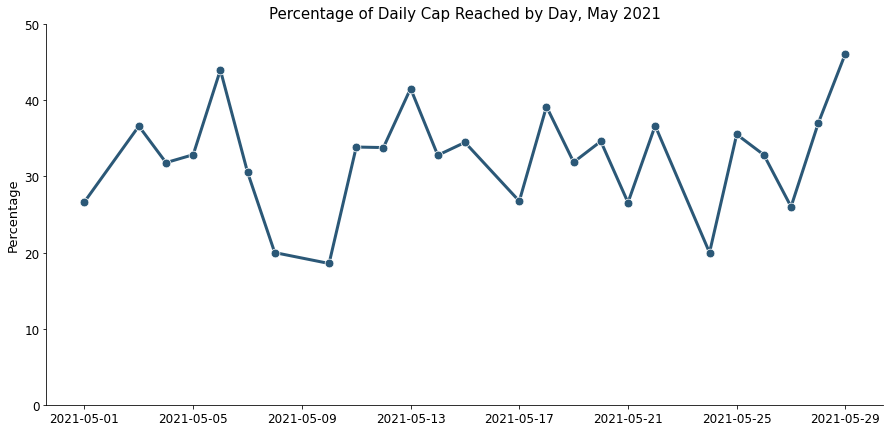

In [26]:
# create line chart for percentage daily cap reached
plt.figure(figsize=(15,7))
ax = sns.lineplot(
    data=daily_cap_sample,
    x=daily_cap_sample.index,
    y='Daily Cap Percent',
    marker='o',
    markersize=8.75,
    linewidth=3,
    color='#2B5877'
)
sns.despine()
plt.title('Percentage of Daily Cap Reached by Day, May 2021', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('Percentage', fontsize=13)
plt.ylim(0, 50)
plt.show()

In [27]:
avg_wkdy_cap_per = daily_cap_sample[daily_cap_sample['Day of Week'] != 'Saturday']['Daily Cap Percent'].mean()
avg_sat_cap_per = daily_cap_sample[daily_cap_sample['Day of Week'] == 'Saturday']['Daily Cap Percent'].mean()

print('Of passengers who use stored value, the average percentage of passengers who reached their daily cap during the week is {:.2f}, while the average percentage for Saturday is {:.2f}'.format(avg_wkdy_cap_per, avg_sat_cap_per))

Of passengers who use stored value, the average percentage of passengers who reached their daily cap during the week is 32.34, while the average percentage for Saturday is 32.79


It appears that daily fare capping is equally utilized on Saturdays and during the week. At least in the month of May. The 32 percent utilization is really interesting because say a passenger uses their TouchPass/Umo account to board a bus in the morning and they pay their fare using stored value. Then in the afternoon, they board a bus paying with their stored value. Because this second transaction meets the daily fare cap limit, this transaction is recorded as having reached their daily fare cap. With this information, it is surprising to see such low utilization of the daily fare capping benefits. 

To demonstrate that last point, let's sample the data set and confirm that is how the system behaves.

In [28]:
sdf[sdf['type'] == 'DAILY_CAP_REACHED'][['cardNumber', 'date_only']].sample(1, random_state=999)

,cardNumber,date_only
8088,8034118865554789,2021-05-27


In [29]:
sdf.loc[(sdf['cardNumber'] == '8034118865554789') & (sdf['date_only'] == pd.to_datetime('2021-05-27'))].sort_values(by='time_only')

,type,mediaType,cardNumber,fareType,routeName,fare,stopName,stopId,passUsed,date,date_only,time_only,geometry
7928,STORED_VALUE,HOUSE_CARD,8034118865554789,Full Fare,3,250,High Point Terminal (Outer Slip),225,NaN,2021-05-27 13:21:12.206000-04:00,2021-05-27,13:21:12.206000,POINT (-80.00729 35.95728)
7948,TRANSFER,HOUSE_CARD,8034118865554789,Full Fare,2,0,Coble Transportation Center,100,NaN,2021-05-27 14:44:08.967000-04:00,2021-05-27,14:44:08.967000,POINT (-79.95934 36.09366)
8088,DAILY_CAP_REACHED,HOUSE_CARD,8034118865554789,Full Fare,2,250,Greensboro Depot,142,NaN,2021-05-27 18:14:16.818000-04:00,2021-05-27,18:14:16.818000,POINT (-79.78680 36.06929)
8102,DAILY_CAP_REACHED,HOUSE_CARD,8034118865554789,Full Fare,3,0,Coble Transportation Center,100,NaN,2021-05-27 18:44:17.441000-04:00,2021-05-27,18:44:17.441000,POINT (-79.95913 36.09392)


The table above confirms our understanding of the TouchPass system. We can see this passenger boarded Route 3 at the High Point Terminal around 1:21 PM. They used their free transfer to board Route 2 at the CTC at 2:45 PM. Then their next transaction occurred around 6:15 PM and is recorded as having reached their daily fare cap. Any subsequent transactions will be recorded as such.

Let's examine how passengers who reach their daily fare cap behave versus those pasesngers who do not. To do this, we will create two data sets. One will contain transactions for days where passengers reached their daily fare cap and the second will contain transactions on days where passengers did not reach their daily fare cap.

In [30]:
%%time
# create empty list to store matching records
cap_data = []
noncap_data = []

for day in may_days:
    # create dataframe for each day
    x = sv_user_trips[sv_user_trips['date_only'] == day]
    
    # get number of unique card numbers who reached their daily fare cap
    daily_cap_reached_cards = x[x['type'] == 'DAILY_CAP_REACHED']['cardNumber'].unique()
    
    # create data set of daily transactions of those users who reached daily fare cap
    daily_cap_trx = (x[x['cardNumber'].isin(daily_cap_reached_cards)])
    nondaily_cap_trx = (x[~x['cardNumber'].isin(daily_cap_reached_cards)])
    
    # append data to list 
    cap_data.append(daily_cap_trx)
    noncap_data.append(nondaily_cap_trx)

# merge data
daily_cap_trx_df = pd.concat(cap_data)
non_daily_cap_trx_df = pd.concat(noncap_data)

Wall time: 146 ms


Let's check to make sure the data was successfully split.

In [31]:
non_daily_cap_trx_df[non_daily_cap_trx_df['type'] == 'DAILY_CAP_REACHED']

,type,mediaType,cardNumber,fareType,routeName,fare,stopName,stopId,passUsed,date,date_only,time_only,geometry


In [32]:
len(sv_user_trips)

4089

In [33]:
len(daily_cap_trx_df) + len(non_daily_cap_trx_df)

4089

Great! We can see that there are no transactions in the non-daily fare cap dataframe where daily fare cap was met. And the length of the stored value dataframe matches the length of the two dataframes we just created.

Let's see how these two groups of passengers access the system.

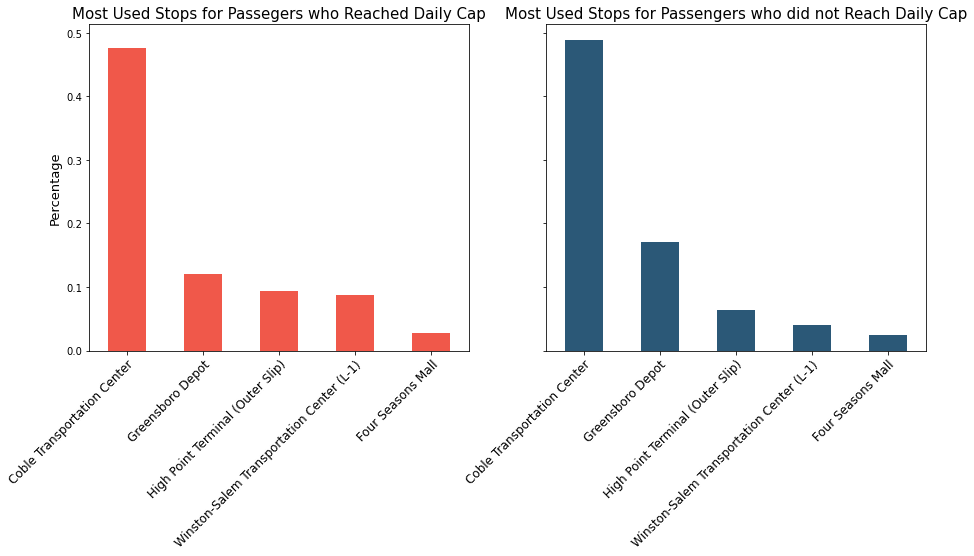

In [34]:
top5_fc_stops = daily_cap_trx_df['stopName'].value_counts(normalize=True)[0:5]
top5_nonfc_stops = non_daily_cap_trx_df['stopName'].value_counts(normalize=True)[0:5]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,6))

top5_fc_stops.plot(kind='bar', color='#F0584A', ax=axes[0])
top5_nonfc_stops.plot(kind='bar', color='#2B5877', ax=axes[1])

axes[0].set_title('Most Used Stops for Passegers who Reached Daily Cap', fontsize=15)
axes[1].set_title('Most Used Stops for Passengers who did not Reach Daily Cap', fontsize=15)

axes[0].set_ylabel('Percentage', fontsize=13)

axes[0].set_xticklabels(labels=top5_fc_stops.index, rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
axes[1].set_xticklabels(labels=top5_nonfc_stops.index, rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)

plt.show()

The two plots above show the top 5 stops for passengers who utilize daily fare capping and for those passengers who use stored value but have not taken advantage of daily fare capping. The counts have been normalized, or converted to percentages, so they can be easily compared. The plots reveal an almost identical distribution. The same five stops appear in both categories of passengers. The majority of activity is centered on the CTC and the other transportation centers.

Let's take a look at time of day.

In [35]:
# create hour attribute in the two dataframes
daily_cap_trx_df['HOUR'] = pd.to_datetime(daily_cap_trx_df['date'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour
non_daily_cap_trx_df['HOUR'] = pd.to_datetime(non_daily_cap_trx_df['date'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour

In [36]:
# group by hour and get a count
daily_cap_users_by_hour = daily_cap_trx_df.groupby('HOUR').size() / 25 # number of weekdays/Saturdays in May
nondaily_cap_users_by_hour = non_daily_cap_trx_df.groupby('HOUR').size() / 25 # number of weekdays/Saturdays in May

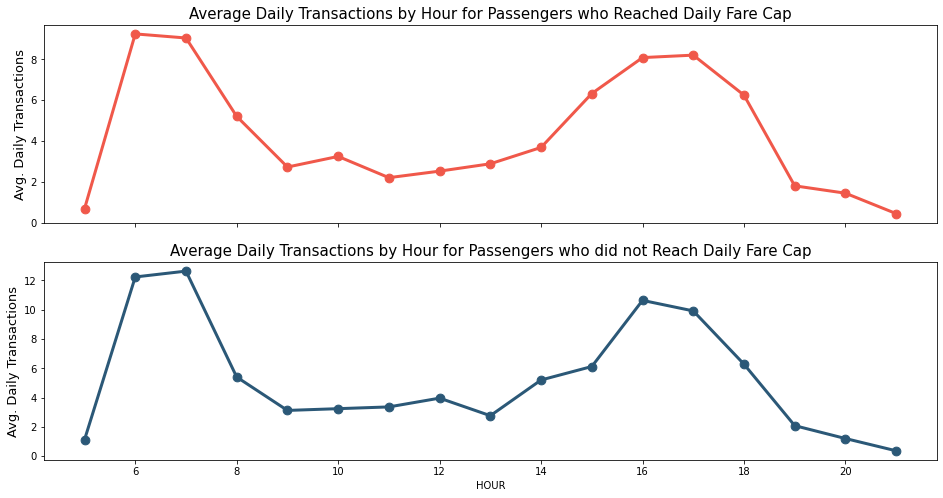

In [37]:
# create subplots to show activity throughout the day
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,8))

daily_cap_users_by_hour.plot(kind='line', marker='o', markersize=8.75, linewidth=3, color='#F0584A', ax=axes[0])
nondaily_cap_users_by_hour.plot(kind='line', marker='o', markersize=8.75, linewidth=3, color='#2B5877', ax=axes[1])

axes[0].set_title('Average Daily Transactions by Hour for Passengers who Reached Daily Fare Cap', fontsize=15)
axes[1].set_title('Average Daily Transactions by Hour for Passengers who did not Reach Daily Fare Cap', fontsize=15)

axes[0].set_ylabel('Avg. Daily Transactions', fontsize=13)
axes[1].set_ylabel('Avg. Daily Transactions', fontsize=13)

plt.show()

The two plots above show the average number of transactions by hour for the two groups we have been analyzing. Both distributions are bimodal with peaks during the morning and afternoon with a mid-day slump. This is not really the expected output. We would have thought that the passengers who did not reach their daily fare cap would utilize the system differently than those who did reach their daily fare cap.

Let me further explain the two data sets so we have a better understanding of what is being displayed. The data set symbolized in the two charts in red represents daily transactions where passengers reached their daily fare cap. The data set symbolized in blue represent daily transactions where the daily fare cap was not reached. So a passenger may have reached their daily fare cap on one day and all of their transactions would be included in the red data set but if they did not reach the fare cap another day, those transactions would be included in the second data set. 

Of those passengers who do use daily fare capping, let's try and see how often they ride.

In [121]:
num_unique_sv = len(sv_users)
num_card_dc = daily_cap_trx_df['cardNumber'].nunique()

print('There are {} unique card numbers who reached their daily fare cap at least once in May 2021'.format(num_card_dc))
print('This means {} percent use stored value and have taken advantage of its benefits'.format(round(num_card_dc / num_unique_sv * 100, 2)))

There are 175 unique card numbers who reached their daily fare cap at least once in May 2021
This means 54.01 percent use stored value and have taken advantage of its benefits


In [152]:
daily_cap_cards_unique_days = daily_cap_trx_df.groupby('cardNumber')['date_only'].nunique().to_frame()
daily_cap_cards_unique_days.rename(columns={'date_only': 'Number of Days'}, inplace=True)

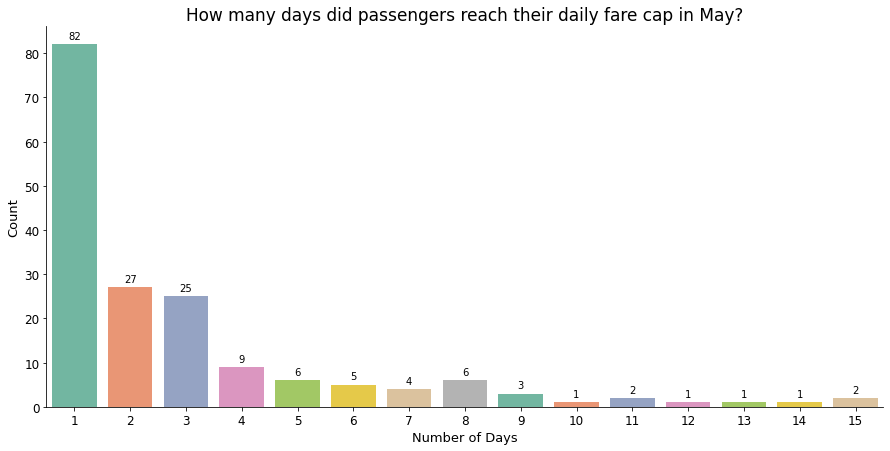

In [162]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=daily_cap_cards_unique_days, x='Number of Days', palette='Set2')
plt.title('How many days did passengers reach their daily fare cap in May?', fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of Days', fontsize=13)
plt.ylabel('Count', fontsize=13)
sns.despine()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1.2, height, ha="center")

plt.show()

The plot above shows the count of passengers and how many days that reached their daily fare cap in the month of May. We can see that 82 passengers only reached their daily fare cap once while two passengers reached their cap on 15 separate days. The majority of passengers use this benefit a handful of days. We do see a slight uptick around eight days. In the plots above, we saw passengers who reached their daily fare cap traveling during peak commute times. We might have assumed that these are commuters who travel regularly and therefore would reach their daily cap much more often than this graph shows. We need to keep digging on this. 

Let's take a look at those folks who never reached their daily fare cap in May.

### Passengers who never reached their daily fare cap

In [38]:
# create data set of card numbers for users who reached their daily fare cap
daily_cap_cardNumbers = sv_user_trips.loc[sv_user_trips['type'] == 'DAILY_CAP_REACHED', 'cardNumber'].unique()

In [39]:
# create data set of trips for those users who never reached daily fare cap
never_daily_cap_user_trips = sv_user_trips[~sv_user_trips['cardNumber'].isin(daily_cap_cardNumbers)]

In [40]:
# create attribute for hour
never_daily_cap_user_trips['HOUR'] = pd.to_datetime(never_daily_cap_user_trips['date'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour

In [41]:
# group by hour and get a count
never_daily_cap_user_trips_by_hours = never_daily_cap_user_trips.groupby('HOUR').size() / 25 # number of weekdays/Saturdays in May

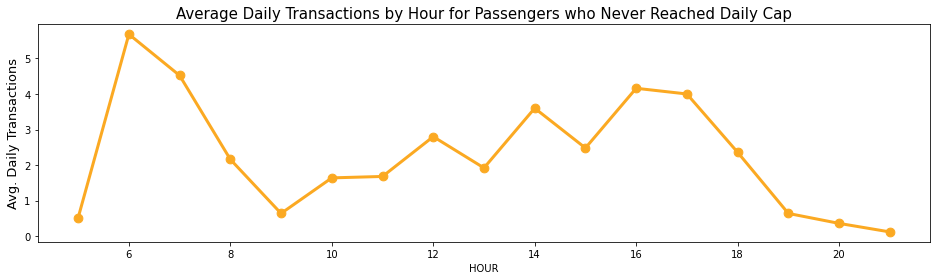

In [42]:
plt.figure(figsize=(16, 4))
never_daily_cap_user_trips_by_hours.plot(kind='line', marker='o', markersize=8.75, linewidth=3, color='#FBA922')
plt.title('Average Daily Transactions by Hour for Passengers who Never Reached Daily Cap', fontsize=15)
plt.ylabel('Avg. Daily Transactions', fontsize=13)
plt.show()

The plot above is showing the average daily transactions by hour for those passengers who never reached their daily fare cap in the month of May. We can see some interesting patterns in the data. We see the early morning peak that may be commuters but the PM peak is not as defined as the two plots above. There is also more activity in the mid-day than in the other data sets. We might speculate that these passengers are not commuters and are using PART for more every day type trips. Another theory is that passengers are traveling between communities for errands and are completing those errands quickly. They then board the PART bus again before their transfer expires in which case, they would not need to use Stored Value and would not reach their daily fare cap. Let's explore this data set further.

Let's find out how many unique card numbers there are in the data set for those who never reached daily fare cap versus those who use stored value.

In [43]:
num_unique_never_dc = never_daily_cap_user_trips['cardNumber'].nunique()

print('There are {} users who never reached their daily fare cap and {} users who use stored value'.format(num_unique_never_dc, num_unique_sv))
print('This means {} percent use stored value but have not taken advantage of its benefits'.format(round(num_unique_never_dc / num_unique_sv * 100, 2)))

There are 149 users who never reached their daily fare cap and 324 users who use stored value
This means 45.99 percent use stored value but have not taken advantage of its benefits


In [109]:
# create variable to remove any observations with invalid coordinates
bad_coord = Point(0, 0)

# plot the transactions for those who never reached their daily fare cap
never_daily_cap_user_trips[~never_daily_cap_user_trips['geometry'].contains(bad_coord)].hvplot(
    geo=True,
    tiles='OSM',
    hover=True,
    hover_cols=[
        'date',
        'routeName',
        'type'
    ],
    c='type',
    size=50,
    frame_width=650,
    frame_height=450
)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (type,date,routeName)

Looking at the plot above, we can see that passengers who do not take advantage of daily fare capping access the PART system across the entire Piedmont region. There are passengers on Routes 1, 2, 3, 4, 6, 9, 10, 17, and all the shuttles. If we zoom in on the CTC, we can see a majority of the transactions are transfers while most of the transactions at the other transit centers are stored value transactions or some kind of pass.

### Other things I need to do

Get number of folks who never transfer

unique passengers per route